## CHEME 5660 Compute of Value at Risk (VaR) for Single Assets and a Portfolio of Assets

## Introduction
The Value at Risk (VaR) is a risk management tool to estimate the potential loss that could occur if an extreme event occurs, i.e., a [Black Swan event](https://www.investopedia.com/articles/trading/11/black-swan-events-investing.asp). In the lecture, we discussed a _back of the envelope_ approach for the calculation of Value at Risk (VaR); we took this approach from [MIT 18.S096](https://ocw.mit.edu/courses/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/resources/mit18_s096f13_lecnote7/). 

The basic idea for a single asset `XYZ`:
* Compute a value for the historical or forward-looking volatility $\sigma$ from OHLC data for `XYZ`.
* Then, the VaR for ticker `XYZ` is $z\sigma$ for an event with z-score $z$

Let's dig into this more and extend this idea to a portfolio of assets. 

## Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-VaR-SingleAsset-Portfolio`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-VaR-SingleAsset-Portfolio/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-VaR-SingleAsset-Portfolio/Manifest.toml`


In [2]:
# load req packages -
using FileIO
using JLD2
using DataFrames
using Dates
using Plots
using Colors
using Distributions
using StatsPlots

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
include("Example-VaR-CodeLib.jl");

In [4]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# setup daily margin rate -
b̂ = 0.065;
margin_rate_daily = ((1+b̂)^(1/365) - 1);

# setup z_array -
z_array = [1.0, 1.96, 2.58, 3.29]; # confidence 68%, 95%, 99% and 99.9%

In [5]:
# load the JLD2 portfolio data file -
price_data_dictionary = clean(load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-11-09-22.jld2"))["dd"]);

# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many ticker symbols do we have?
Nₐ = length(ticker_symbol_array);

Length violation: META was removed; dim(SPY) = 505 days and dim(META) = 255 days


### a) Back-of-the-envelope VaR calculation for a single-risky asset

In [6]:
# what asset are calculating the VaR for?
single_ticker_symbol = "AMD"
start_index = 66;

# what is AMD IV?
IV = 58.88;

# How many days do we want to look at in the future?
T = 1+1; # units: days

# grab some data for AMD -
price_data_df = price_data_dictionary[single_ticker_symbol];
price_data = price_data_dictionary[single_ticker_symbol][end-start_index:end,:close];

# What is Sₒ?
Sₒ = price_data[end];

In [7]:
# compute σ -
σ = Sₒ*(IV/100)*sqrt(1/365);

In [8]:
# Back of the envolope calculation of the VaR -
# Let's do a 99% confidence level
VaR_ms = (z_array[3]*σ*(1/Sₒ))*100 # on any given trading day

# output -
println("VaR back of the envolpe; we can expect to lose no more than $(VaR_ms)% on our $(single_ticker_symbol) position 99% of trading days")

VaR back of the envolpe; we can expect to lose no more than 7.951353745024839% on our AMD position 99% of trading days


### b) Where does that number come from: let's dig into this VaR number of little bit more ...

In [9]:
# How many days are we looking at?
T′ = 30 + 1;

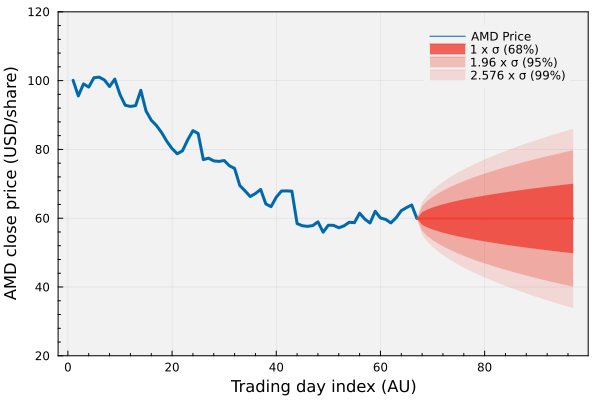

In [10]:
# make a cone plot -
future_array = Array{Float64,2}(undef, T′, 8)
for i ∈ 1:T′
    
    # compute σ -
    σ_L = Sₒ*(IV/100)*sqrt((i-1)/365);

    future_array[i,1] = i+start_index;
    future_array[i,2] = Sₒ
    future_array[i,3] = Sₒ + σ_L
    future_array[i,4] = Sₒ - σ_L
    future_array[i,5] = Sₒ + 1.96*σ_L
    future_array[i,6] = Sₒ - 1.96*σ_L
    future_array[i,7] = Sₒ + 2.576*σ_L
    future_array[i,8] = Sₒ - 2.576*σ_L
end


# plot the historical data -
plot(price_data_df[end-start_index:end,:close], lw=3, c=colorant"#0068AC", label="AMD Price", ylim=(20.0, 120))
plot!(future_array[:,1], future_array[:,2], c=colorant"#EF4035", minorticks=2.0,
    lw=2, bg=colorant"#F2F2F2", background_color_outside="white", framestyle = :box, fg_legend = :transparent, label="")

plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,3], c=colorant"#EF4035", alpha=0.8, label="")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,4], c=colorant"#EF4035", alpha=0.8, label="1 x σ (68%)")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,5], c=colorant"#EF4035", alpha=0.3, label="")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,6], c=colorant"#EF4035", alpha=0.3, label="1.96 x σ (95%)")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,7], c=colorant"#EF4035", alpha=0.15, label="")
plot!(future_array[:,1], future_array[:,2], fillrange=future_array[:,8], c=colorant"#EF4035", alpha=0.15, label="2.576 x σ (99%)")

xlabel!("Trading day index (AU)", fontsize=18)
ylabel!("AMD close price (USD/share)", fontsize=18)

In [11]:
# compute the distribution for sampling -
d = Normal(Sₒ, σ);

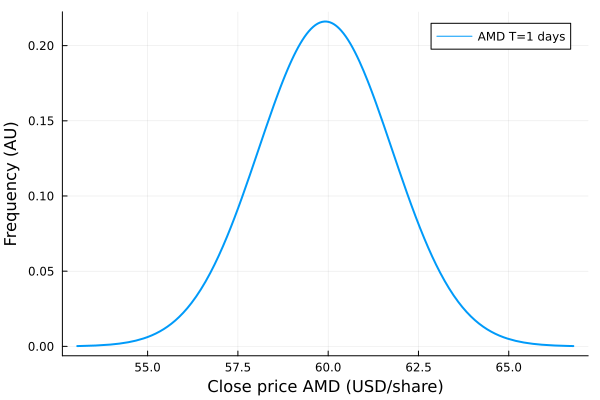

In [12]:
plot(d, label="$(single_ticker_symbol) T=$(T-1) days", lw=2)
xlabel!("Close price $(single_ticker_symbol) (USD/share)", fontsize=18)
ylabel!("Frequency (AU)", fontsize=18)

In [13]:
S_range = range(Sₒ - z_array[4]*σ, stop = Sₒ + z_array[4]*σ, step=0.01) |> collect;
cdf_array = Array{Float64, 2}(undef, length(S_range), 2);

for i ∈ 1:length(S_range)
    
    Sᵢ = S_range[i];
    cdf_value = cdf(d, Sᵢ);
    
    cdf_array[i,1] = Sᵢ;
    cdf_array[i,2] = cdf_value;
end

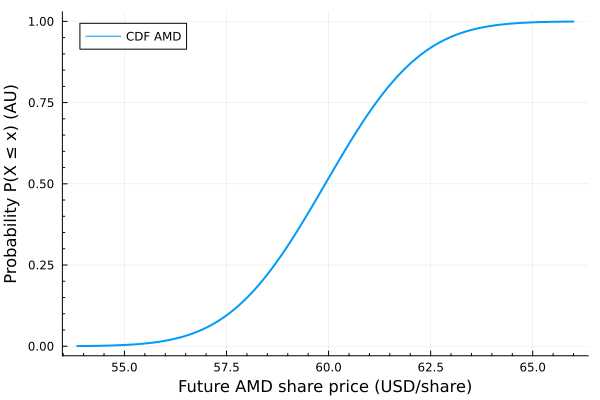

In [14]:
plot(cdf_array[:,1], cdf_array[:,2], label="CDF $(single_ticker_symbol)", legend=:topleft, lw=2, minorticks=0.2)
xlabel!("Future $(single_ticker_symbol) share price (USD/share)", fontsize=18)
ylabel!("Probability P(X ≤ x) (AU)", fontsize=18)

#### What is the price and return values for a 1% event (a 99% chance rare event does not happen)?

In [15]:
Ŝ = Sₒ - z_array[3]*σ;
println("$(single_ticker_symbol) share price for a rare event $(T-1)-days in the future: $(Ŝ) (USD/share)")

AMD share price for a rare event 1-days in the future: 55.155548835981115 (USD/share)


In [16]:
# What is the probability of this rare event happening?
P_gt_Ŝ = 1 - cdf(d,Ŝ);
println("The probability that $(single_ticker_symbol) will close above $(Ŝ) (USD/share) $(T-1)-days in the future is $(P_gt_Ŝ*100)%")

The probability that AMD will close above 55.155548835981115 (USD/share) 1-days in the future is 99.50599842422294%


In [17]:
# what is the loss *if* we get a 1% event -
R_bs = ((Ŝ - Sₒ)/Sₒ)*100
println("However, if the rare event occurs $(T-1)-days in the future, our return could be $(R_bs)%")

However, if the rare event occurs 1-days in the future, our return could be -7.951353745024845%


### c) How could we extend this idea to a portfolio of assets?

One obvious way to do this would be to compute the cumulative distributions (and the associated rare event returns) for every asset in the portfolio. Then, we could compute the portfolio return $R_{\mathcal{P}}$ as:

$$R_{\mathcal{P}} = \omega^{T}R+\left(1-\sum_{a\in\mathcal{P}}\omega_{a}\right)r_{f}$$

where $\omega^{T}$ denotes the transpose of the allocation vector, $R$ denotes the return vector, and $r_{f}$ denotes the risk free rate. However, suppose we constructed our portfolio using [Single Index Models (SIMs)](https://en.wikipedia.org/wiki/Single-index_model). In that case, we only need to compute the extreme event return for our market factor, namely [SPY](https://finance.yahoo.com/quote/SPY?p=SPY&.tsrc=fin-srch), and then use our collection of SIMs to compute the return of each risky asset.

In [18]:
# compute SPY rare event return -
market_ticker_symbol = "SPY"

# what is SPY IV?
IV_SPY = 25.23;

# How many days do we want to look at in the future?
T = 1+1; # units: days

# grab some data for AMD -
market_price_data_df = price_data_dictionary[market_ticker_symbol];
market_price_data = price_data_dictionary[market_ticker_symbol][end-start_index:end,:close];

# What is Sₒ?
Mₒ = market_price_data[end];

# compute σ -
σ_M = Mₒ*(IV_SPY/100)*sqrt(1/365);

# compute the distribution for sampling -
d_M = Normal(Mₒ, σ_M);

In [19]:
M_range = range(Mₒ - z_array[4]*σ_M, stop = Mₒ + z_array[4]*σ_M, step=0.01) |> collect;
cdf_array_market = Array{Float64, 2}(undef, length(M_range), 2);

for i ∈ 1:length(M_range)
    
    Mᵢ = M_range[i];
    cdf_value = cdf(d_M, Mᵢ);
    
    cdf_array_market[i,1] = Mᵢ;
    cdf_array_market[i,2] = cdf_value;
end

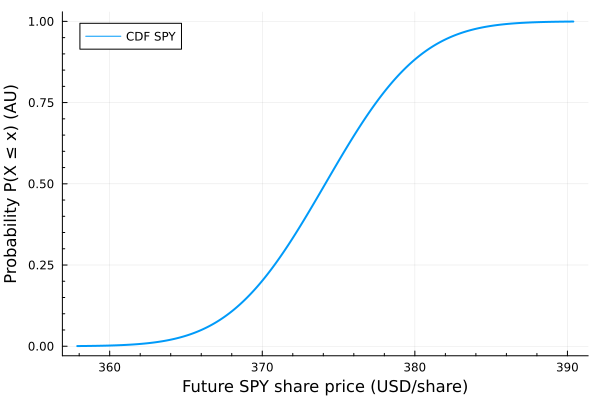

In [20]:
plot(cdf_array_market[:,1], cdf_array_market[:,2], label="CDF $(market_ticker_symbol)", legend=:topleft, lw=2, minorticks=0.2)
xlabel!("Future $(market_ticker_symbol) share price (USD/share)", fontsize=18)
ylabel!("Probability P(X ≤ x) (AU)", fontsize=18)

In [24]:
M̂ = Mₒ - z_array[2]*σ_M;
println("$(market_ticker_symbol) share price for a rare event $(T-1)-days in the future: $(M̂) (USD/share)")

SPY share price for a rare event 1-days in the future: 364.4461194548797 (USD/share)


In [25]:
# What is the probability of this rare event happening?
P_gt_M̂ = 1 - cdf(d_M,M̂);
println("The probability that $(market_ticker_symbol) will close above $(M̂) (USD/share) $(T-1)-days in the future is $(P_gt_M̂*100)%")

The probability that SPY will close above 364.4461194548797 (USD/share) 1-days in the future is 97.50021048517797%


In [26]:
# what is the loss *if* we get a 1% event -
R_bs_M = ((M̂ - Mₒ)/Mₒ)*100
println("However, if the rare event occurs $(T-1)-days in the future, our return could be $(R_bs_M)%")

However, if the rare event occurs 1-days in the future, our return could be -2.588373171122418%


### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.